# Example Notebook for TCN-GRU model

In [1]:
from tcn_sequence_models.data_processing.preprocessor import Preprocessor
from tcn_sequence_models.models import TCN_GRU
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import os
from tcn_sequence_models.utils.scaling import inverse_scale_sequences
import numpy as np

2022-07-05 20:59:49.291417: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/michael/Projects/TCN_Seq2Seq/venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [2]:
#set config_path to a path on your system. There, the model and preprocessor configs
# will be saved to.
config_path = "./config_TCN_GRU"
os.makedirs(name=config_path, exist_ok=True)

## Load and process data

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv"
df = pd.read_csv(url)

In [4]:
time_col = 'DateTime'
df[time_col]= pd.to_datetime(df[time_col])

In [5]:
# Define features to use
features_input_encoder = [
    "Temperature",
    "Humidity",
    "Wind Speed",
    "general diffuse flows",
    "diffuse flows"
]

features_input_decoder = [
]

feature_target = "Zone 1 Power Consumption"

In [6]:
# Add temporal encodings. Possible are: 'seasons', 'months', 'weekdays' and 'hours'
temporal_encoding_modes = ["weekdays", "hours"]

In [7]:
split_ratio = 0.7
input_seq_len = 100
output_seq_len = 50

In [8]:
preprocessor = Preprocessor(df)

In [9]:
# split_date = datetime.date(2019, 1, 1)
preprocessor.process(
    features_input_encoder,
    features_input_decoder,
    feature_target,
    input_seq_len,
    output_seq_len,
    model_type="tcn_gru",
    time_col=time_col,
    split_ratio = split_ratio,
    split_date = None,
    temporal_encoding_modes=temporal_encoding_modes,
    )

In [10]:
X_train, y_train, X_val, y_val = preprocessor.train_test_split(split_ratio)

## Create model and fit it

In [11]:
from tensorflow.keras.optimizers import Adam
model = TCN_GRU()

model.build(
    hidden_units = 6,
    num_filters = 6,
    kernel_size_enc = 3,
    dilation_base = 2,
    output_size_attention = 2,
    dropout_rate = 0.2,
    gru_output_neurons = [16],
    key_size = 6,
    value_size = 6,
    num_attention_heads = 2,
    activation = "relu",
    kernel_initializer = "he_normal",
    padding_enc = "same",
    batch_norm = True,
    layer_norm = False,)
model.compile(optimizer=Adam(lr=0.03, decay=1e-3))



2022-07-05 21:00:00.588098: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-05 21:00:00.649912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7715GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 238.66GiB/s
2022-07-05 21:00:00.649961: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-05 21:00:00.653304: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-05 21:00:00.653365: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-07-05 21:00:00.654975: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [12]:
cb_early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train,
          y_train,
          (X_val, y_val),
          epochs=5,
          batch_size=64,
          callbacks = cb_early_stopping
          )

2022-07-05 21:00:01.324591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-05 21:00:01.325080: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3193680000 Hz


Epoch 1/5


2022-07-05 21:01:13.039448: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-07-05 21:01:13.453037: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2022-07-05 21:01:13.847021: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-05 21:01:13.847055: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-07-05 21:01:13.847589: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-05 21:01:13.847643: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-05 21:01:13.857486: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

571/571 [==============================] - 233s 274ms/step - loss: 0.1103 - val_loss: 0.1546
Epoch 2/5
571/571 [==============================] - 137s 240ms/step - loss: 0.0725 - val_loss: 0.1605
Epoch 3/5
571/571 [==============================] - 138s 242ms/step - loss: 0.0640 - val_loss: 0.2307
Epoch 4/5
571/571 [==============================] - 136s 238ms/step - loss: 0.0588 - val_loss: 0.2744


## Make predictions

In [13]:
y_pred = model.predict(X_val)

In [14]:
y_pred_unscaled = inverse_scale_sequences(np.expand_dims(y_pred, axis=-1), preprocessor
                                          .scaler_y)
y_val_unscaled = inverse_scale_sequences(np.expand_dims(y_val, axis=-1),
                                                        preprocessor.scaler_y)

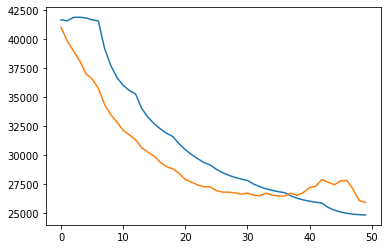

In [15]:
plt.plot(y_pred_unscaled[3000])
plt.plot(y_val_unscaled[3000])
plt.show()

## Save the preprocessor and the model

In [25]:
preprocessor.save_preprocessor_config(save_path=config_path)

In [26]:
model.save_model(config_path)

## Load the saved preprocessor and model

In [27]:
preprocessor_loaded = Preprocessor(df)
preprocessor_loaded.load_preprocessor_config(load_path=config_path)

In [29]:
# Load with the intention to only use the model for inference. If the model shall be
# trained, use process_from_config_training() and the get the training data with the
# train_test_split() method.
preprocessor_loaded.process_from_config_inference()

In [30]:
model_loaded = TCN_GRU()

In [31]:
model_loaded.load_model(config_path, preprocessor_loaded.X, is_training_data=False)

In [32]:
y_pred = model_loaded.predict(preprocessor_loaded.X)

In [42]:
y_pred_unscaled = inverse_scale_sequences(np.expand_dims(y_pred, axis=-1),
                                          preprocessor_loaded.scaler_y)
y_true_unscaled = inverse_scale_sequences(np.expand_dims(preprocessor.y,
                                                         axis=-1),
                                                        preprocessor_loaded.scaler_y)

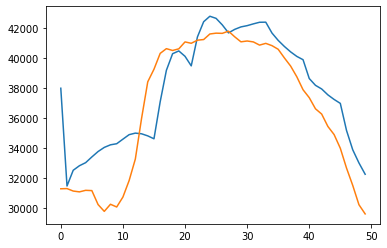

In [47]:
plt.plot(y_pred_unscaled[1000])
plt.plot(y_true_unscaled[1000])
plt.show()

## Run bayessian optimizer to find the optimal hyperparameters

In [48]:
model.parameter_search(
        X_train,
        y_train,
        X_val,
        y_val,
        batch_size = 64,
        results_path = "param_search_new/search_8",
        patience=2,
        loss = "mse",
        max_trials = 2,
        executions_per_trial = 1,
        hidden_units = [2, 4, 6],
        num_filters = [6, 10, 14, 18],
        kernel_size_enc = [3, 5],
        dilation_base = [2],
        dropout_rate = [0.1, 0.2],
        gru_output_neurons = [16],
        key_value_size = [6, 8, 10],
        num_attention_heads = [2],
        output_size_attention = [8],
        activation = ["elu"],
        kernel_initializer = ["he_normal"],
        padding_enc = ["causal"],
        batch_norm = [False],
        layer_norm = [True],
    )



Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
num_filters       |14                |?                 
kernel_size_enc   |5                 |?                 
dilation_base     |2                 |?                 
output_size_att...|8                 |?                 
dropout_rate      |0.1               |?                 
gru_output_neurons|16                |?                 
key_size          |6                 |?                 
num_attention_h...|2                 |?                 
activation        |elu               |?                 
kernel_initializer|he_normal         |?                 
padding_enc       |causal            |?                 
batch_norm        |0                 |?                 
layer_norm        |1                 |?                 

Epoch 1/50
571/571 [==============================] - 214s 257ms/step - loss: 0.1150 - val_loss: 0.2177
Epoch 2/50
 70/571 [==>...........................] - ETA: 1:41 - loss

KeyboardInterrupt: 